# Data Exploration

## Preliminaries

In [1]:
# imports
import duckdb
import matplotlib.pyplot as plt
from merlion.models.factory import ModelFactory
from online_conformal.dataset import M4
from online_conformal.visualize import plot_simulated_forecast

## Reading in data

In [2]:
regn_data = duckdb.sql(
    """select * 
       from 'test_data/regn_20230103_to_20230331.csv.gz' 
       where DATE = '2023-01-03'
       order by TIME_M """).df()

In [3]:
regn_data

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_STOP_IND,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
0,2023-01-03,04:00:00.166684,P,REGN,NaN,@ TI,1,743.14,NaN,00,1950,1,N,NaN
1,2023-01-03,04:33:58.480628,K,REGN,NaN,@ TI,10,724.00,NaN,00,5944,1,N,NaN
2,2023-01-03,04:33:58.510989,P,REGN,NaN,@ TI,1,723.12,NaN,00,5945,2,N,NaN
3,2023-01-03,04:34:03.641957,K,REGN,NaN,@ TI,7,724.00,NaN,00,5968,2,N,NaN
4,2023-01-03,07:08:43.989827,P,REGN,NaN,@FTI,1,725.00,NaN,00,29310,3,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,2023-01-03,16:35:21.79902,D,REGN,NaN,@ TI,10,720.47,NaN,00,5045639,3559,N,Q
17115,2023-01-03,16:53:35.057812,D,REGN,NaN,@ TW,2131,720.47,NaN,00,5048337,3560,N,Q
17116,2023-01-03,18:34:47.018832,K,REGN,NaN,@ TI,1,712.43,NaN,00,5054550,718,N,NaN
17117,2023-01-03,19:51:44.31738,P,REGN,NaN,@FTI,10,718.80,NaN,00,5062153,1620,N,NaN


In [4]:
# Create lag columns
regn_data['lag_1'] = regn_data['PRICE'].shift(1)  # Lag by 1 period
regn_data['lag_2'] = regn_data['PRICE'].shift(2)  # Lag by 2 periods
regn_data['lag_3'] = regn_data['PRICE'].shift(3)  # Lag by 3 periods

In [9]:
regn_data = regn_data.dropna(subset=['lag_1', 'lag_2', 'lag_3'])[:16000] # cut off closing

A simple visual of REGN's stock price:

In [11]:
regn_data["dollar_volume"] = regn_data["PRICE"] * regn_data["SIZE"]

<AxesSubplot:>

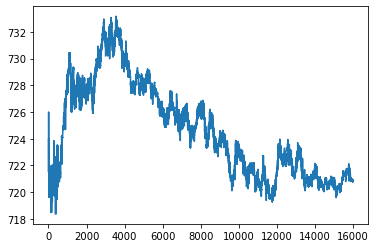

In [12]:
regn_data.PRICE.plot()

<AxesSubplot:>

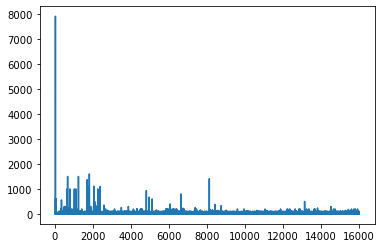

In [13]:
regn_data.SIZE.plot()

## Test Mondrian Forest

In [14]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target

In [15]:
### Use MondrianForests for variance estimation
from skgarden import MondrianForestRegressor
mfr = MondrianForestRegressor()
mfr.fit(X, y)
y_mean, y_std = mfr.predict(X, return_std=True)

/opt/anaconda3/envs/thesis36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/opt/anaconda3/envs/thesis36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [16]:
y_mean

array([24.        , 21.60000038, 34.70000076, 33.40000153, 36.20000076,
       28.70000076, 22.89999962, 27.10000038, 16.5       , 18.89999962,
       15.        , 18.89999962, 21.70000076, 20.39999962, 18.20000076,
       19.89999962, 23.10000038, 17.5       , 20.20000076, 18.20000076,
       13.60000038, 19.60000038, 15.19999981, 14.5       , 15.60000038,
       13.89999962, 16.60000038, 14.80000019, 18.39999962, 21.        ,
       12.69999981, 14.5       , 13.19999981, 13.10000038, 13.5       ,
       18.89999962, 20.        , 21.        , 24.70000076, 30.79999924,
       34.90000153, 26.60000038, 25.29999924, 24.70000076, 21.20000076,
       19.29999924, 20.        , 16.60000038, 14.39999962, 19.39999962,
       19.70000076, 20.5       , 25.        , 23.39999962, 18.89999962,
       35.40000153, 24.70000076, 31.60000038, 23.29999924, 19.60000038,
       18.70000076, 16.        , 22.20000076, 25.        , 33.        ,
       23.5       , 19.39999962, 22.        , 17.39999962, 20.89

In [17]:
X = regn_data[["lag_1", "lag_2", "lag_3", "SIZE"]].to_numpy()
y = regn_data.PRICE.to_numpy()

In [18]:
len(X)

16000

In [19]:
X_train, y_train, X_test, y_test = X[:14000], y[:14000], X[14000:], y[14000:]

In [20]:
### Use MondrianForests for variance estimation
from skgarden import MondrianForestRegressor

mfr = MondrianForestRegressor()
mfr.fit(X_train, y_train)
y_mean, y_std = mfr.predict(X_test, return_std=True)

In [21]:
import numpy as np
np.abs(y_mean - y_test).mean()

0.1165430932832021

In [22]:
y_mean

array([721.76156006, 721.59688721, 721.50273438, ..., 720.7833374 ,
       720.80515747, 720.80515747])

In [23]:
y_std

array([0.19473517, 0.27590419, 0.0861069 , ..., 0.145424  , 0.14777901,
       0.14777901])

In [24]:
y_test

array([721.49, 721.49, 721.49, ..., 720.81, 720.81, 720.8 ])

In [25]:
len(y_test)

2000

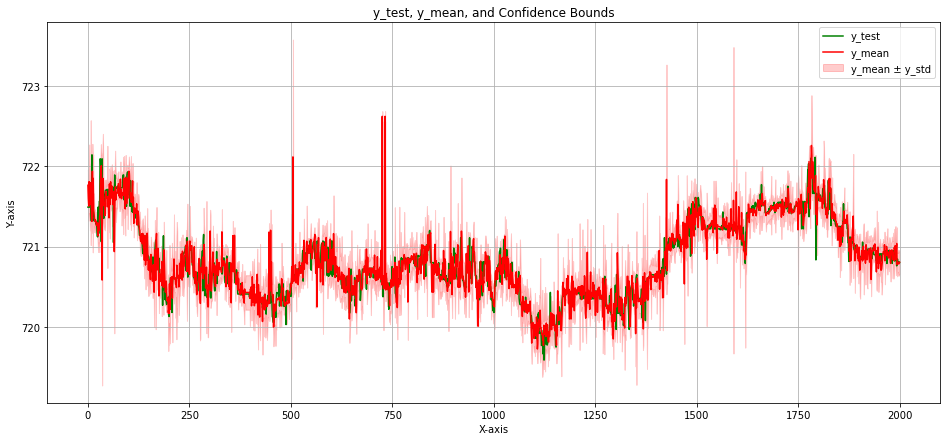

In [26]:
import numpy as np
import matplotlib.pyplot as plt

x = list(range(len(y_test))) 

# Plotting
plt.figure(figsize=(16, 7))

# Plot y_test in green
plt.plot(x, y_test, color='green', label='y_test')

# Plot y_mean in red
plt.plot(x, y_mean, color='red', label='y_mean')

# Shaded region for y_mean ± y_std
plt.fill_between(x, y_mean - y_std, y_mean + y_std, color='red', alpha=0.2, label='y_mean ± y_std')

# Adding labels, legend, and grid
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('y_test, y_mean, and Confidence Bounds')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [28]:
import numpy as np
import plotly.graph_objects as go
# Create Plotly figure
fig = go.Figure()

# Add y_test in green
fig.add_trace(go.Scatter(
    x=x, y=y_test,
    mode='lines',
    line=dict(color='green'),
    name='y_test'
))

# Add y_mean in red
fig.add_trace(go.Scatter(
    x=x, y=y_mean,
    mode='lines',
    line=dict(color='red'),
    name='y_mean'
))

# Add shaded area for y_mean ± y_std
fig.add_trace(go.Scatter(
    x=np.concatenate([x, x[::-1]]),
    y=np.concatenate([y_mean + 3*y_std, (y_mean - 3*y_std)[::-1]]),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.2)',  # Transparent red
    line=dict(color='rgba(255, 0, 0, 0)'),  # No border
    name='y_mean ± y_std'
))

# Customize layout
fig.update_layout(
    title='Interactive Plot: y_test, y_mean, and Confidence Bounds',
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    legend=dict(title='Legend'),
    template='plotly_white',
)

# Show interactive plot
fig.write_html("interactive_plot.html")